# Q-learning with neural networks

In [1]:
# a few packages we need to import
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
from tqdm import tqdm
from matplotlib.colors import BoundaryNorm

import torch

import pendulum
torch.random.manual_seed(412)

The goal of this homework is to implement the Q-learning with a neural network for the Q function to solve the inverted pendulum problem.

<img src='pendulum.png' width="120">

In the following, we write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system.

## System dynamics
* The system dynamics is implemented in the `pendulum.py` function. The dynamics is implemented in `pendulum.step`.
* The allowed control inputs are $[-5,0,5]$

## Cost function
The goal is to find a policy that minimizes the following cost
$$\min \sum_{n=0}^N \alpha^n g(x,u)$$
where
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.001* v^2 + 0.00001*u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls



## Q-learning algorithm to implement
For each episode:
* Initialize the episode $x_0 = [0,0]$
* For each step of the episode:
    * Select $u_n$ using an $\epsilon$-greedy policy
    * Compute the next state $x_{n+1}$
    * Compute the target $y_n = g(x_n,u_n) + \alpha \min_a Q(x_{n+1},a)$
    * Do one SGD step on the neural network parameters to minimize $(Q(x,u) - y_t)^2$


## Parameters:
* Episode length 100 steps
* Discount factor $\alpha = 0,99$
* Learning rate (for SGD) 0.1
* $\epsilon = 0.1$



## Using PyTorch
You need to install and use PyTorch for the neural network and do the optimization. 

You may want to use the following functions:
* [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

The neural network is given below

In [2]:
## we define the neural network to be used for Q-learning
## 2 hidden layers with 64 nodes
## 2 inputs (state)
## 3 outputs for the 3 possible controls
D_in, H, D_out = 2, 64, 3

q_function = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

## we initialize the network parameters to 0
for params in q_function.parameters():
    params = torch.zeros_like(params)


### possible controls
possible_controls = np.array([-5.,0.,5.])

# Questions:
1. Implement the Q-learning algorithm described above
2. Test that it works with and without pushes using the code below
3. Plot the cost per episode (to visualize learning)
4. Plot the learned value function (in 2D as a function of pendulum position and velocity) as well as the policy.
5. Describe the algorithm and put the plots in a short report (max 2 pages) and include a video of the pendulum.

## Testing
You can test your results with the code below which use the Q-function to create a controller send to the `animate_robot` function.
You can choose to save also a movie of the animation and toggle the animation with a disturbance.

In [3]:
class QLearning:
    def __init__(self, q_function, possible_controls, alpha=0.99, epsilon=0.1, episodes=20000, episode_length=100, learning_rate=0.1):
        self.q_function = q_function
        self.possible_controls = possible_controls
        self.alpha = alpha
        self.epsilon = epsilon
        self.episodes = episodes
        self.episode_length = episode_length
        self.learning_rate = learning_rate
        self.loss_list = []
        self.cost_list = []

    def cost_function(self, x, u):
        # Convert to torch tensors if needed        
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, dtype=torch.float32)
        
        # Compute the cost using PyTorch operations
        return 0.01 * (1 - torch.cos(x[0] - np.pi))**2 + 0.001 * x[1]**2 + 0.00001 * u**2

    def train(self):
        optimizer = torch.optim.SGD(q_function.parameters(), lr=self.learning_rate)
        loss_fn = torch.nn.MSELoss()
        # loss_list = []
        # cost_list = []
        for episode in tqdm(range(self.episodes), desc='Running episodes'):
            x = torch.tensor([0., 0.])
            for step in range(self.episode_length):
                # Select u_n using an epsilon-greedy policy
                if np.random.rand() < self.epsilon:
                    u_n = np.random.choice(self.possible_controls)
                else:
                    u_pred = torch.argmin(self.q_function(torch.as_tensor(x, dtype=torch.float32).unsqueeze(0))).item()
                    u_n = self.possible_controls[u_pred]

                # Compute the next state x_{n+1}
                x_next = pendulum.step(x, u_n)

                # Compute the target y_n
                g_value = self.cost_function(x, u_n)
                q_value = self.q_function(torch.as_tensor(x_next, dtype=torch.float32).unsqueeze(0)).detach()

                y = g_value + self.alpha * torch.min(q_value)

                # Update the Q-function
                q_value = self.q_function(torch.as_tensor(x, dtype=torch.float32).unsqueeze(0))
                target = q_value.clone().detach()
                u_index = np.where(self.possible_controls == u_n)[0][0]
                target[0, u_index] = y

                # Compute the loss
                loss = loss_fn(q_value, target)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update the state
                x = x_next

            # Store the loss and cost
            self.loss_list.append(loss.item())
            self.cost_list.append(g_value.item())
                

    def controller(self, x):
        u_pred = torch.argmin(self.q_function(torch.as_tensor(x, dtype=torch.float32).unsqueeze(0))).item()
        u = self.possible_controls[u_pred]
        return u
    
    def plot_results(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_list)
        plt.title('Loss')
        plt.figure(figsize=(10, 5))
        plt.plot(self.cost_list)
        plt.title('Cost')
        plt.show()

    def plot_value_function(self, q_function):
        # We need to plot a the learned value function in 2D as a function of pendulum position and velocity with virdis
        theta = np.linspace(-np.pi, np.pi, 100)
        velocity = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(theta, velocity)
        value_grid = np.zeros_like(X)
        policy_grid = np.zeros_like(X)

        for i in range(100):
            for j in range(100):
                x = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)
                value_grid[i, j] = torch.min(q_function(x.unsqueeze(0))).item()
                policy_grid[i, j] = torch.argmin(q_function(x.unsqueeze(0))).item()        

        plt.figure(figsize=(10, 5))
        plt.contourf(X, Y, value_grid, cmap='viridis')
        plt.colorbar()
        plt.title('Value function')

    def plot_value_function_and_policy(self, q_function, possible_controls, position_range=(-np.pi, np.pi), velocity_range=(-8, 8), grid_size=100):
        """
        Plots the learned value function and the policy in 2D as a function of pendulum position and velocity.

        Parameters:
            q_function (torch.nn.Module): The trained Q-function neural network.
            possible_controls (list or np.array): Possible control actions.
            position_range (tuple): Range of pendulum positions to consider.
            velocity_range (tuple): Range of pendulum velocities to consider.
            grid_size (int): Resolution of the grid for plotting.
        """
        # Create a grid of positions and velocities
        positions = np.linspace(*position_range, grid_size)
        velocities = np.linspace(*velocity_range, grid_size)
        position_grid, velocity_grid = np.meshgrid(positions, velocities)

        # Initialize arrays for the value function and policy
        value_grid = np.zeros_like(position_grid)
        policy_grid = np.zeros_like(position_grid)
        
        # Evaluate the Q-function for each grid point
        for i in range(grid_size):
            for j in range(grid_size):
                state = torch.tensor([position_grid[i, j], velocity_grid[i, j]], dtype=torch.float32)
                q_values = q_function(state.unsqueeze(0)).detach().numpy().flatten()
                value_grid[i, j] = np.min(q_values)
                policy_grid[i, j] = possible_controls[np.argmin(q_values)]

        # Plot the value function
        plt.figure(figsize=(10, 6))
        plt.contourf(position_grid, velocity_grid, value_grid, levels=100)
        plt.colorbar(label='Value Function')
        plt.title('Learned Value Function')
        plt.xlabel('Pendulum Position (rad)')
        plt.ylabel('Pendulum Velocity (rad/s)')
        plt.show()

        # Plot the policy
        plt.figure(figsize=(10, 6))

        # Define boundaries and colormap for the discrete policy values
        levels = [-6, -2.5, 2.5, 6]  # Boundaries for -5, 0, 5
        cmap = plt.cm.viridis
        norm = BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)

        contour = plt.contourf(position_grid, velocity_grid, policy_grid, levels=levels, cmap=cmap, norm=norm)
        cbar = plt.colorbar(contour, ticks=[-5, 0, 5])  # Set color bar ticks to match control values
        cbar.set_label('Policy (Control)')
        plt.title('Learned Policy')
        plt.xlabel('Pendulum Position (rad)')
        plt.ylabel('Pendulum Velocity (rad/s)')
        plt.show()

        # # Plot the value function
        # # Create a grid of positions and velocities
        # positions = np.linspace(*position_range, grid_size)
        # velocities = np.linspace(*velocity_range, grid_size)
        # position_grid, velocity_grid = np.meshgrid(positions, velocities)

        # # Initialize arrays for the value function and policy
        # value_grid = np.zeros_like(position_grid)
        # policy_grid = np.zeros_like(position_grid)

        # # Evaluate the Q-function for each grid point
        # for i in range(grid_size):
        #     for j in range(grid_size):
        #         state = torch.tensor([position_grid[i, j], velocity_grid[i, j]], dtype=torch.float32)
        #         q_values = q_function(state.unsqueeze(0)).detach().numpy().flatten()
        #         value_grid[i, j] = np.min(q_values)  # Value function
        #         policy_grid[i, j] = possible_controls[np.argmin(q_values)]  # Policy

        # # Plot the value function
        # plt.figure(figsize=(10, 6))
        # plt.contourf(position_grid, velocity_grid, value_grid, levels=100)
        # plt.colorbar(label='Value Function')
        # plt.title('Learned Value Function')
        # plt.xlabel('Pendulum Position (rad)')
        # plt.ylabel('Pendulum Velocity (rad/s)')
        # plt.show()

        # # Plot the policy
        # # Plot the policy
        # plt.figure(figsize=(10, 6))

        # # Define boundaries and colormap for the discrete policy values
        # levels = [-6, -2.5, 2.5, 6]  # Boundaries for -5, 0, 5
        # cmap = plt.cm.viridis
        # norm = BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)

        # contour = plt.contourf(position_grid, velocity_grid, policy_grid, levels=levels, cmap=cmap, norm=norm)
        # cbar = plt.colorbar(contour, ticks=[-5, 0, 5])  # Set color bar ticks to match control values
        # cbar.set_label('Policy (Control)')

        # plt.title('Learned Policy')
        # plt.xlabel('Pendulum Position (rad)')
        # plt.ylabel('Pendulum Velocity (rad/s)')
        # plt.show()



            
                

            

In [4]:
# Call the class and the train function
InvPen = QLearning(q_function, possible_controls)
InvPen.train()


Running episodes: 100%|██████████| 20000/20000 [33:43<00:00,  9.88it/s]


In [5]:
x0 = np.zeros((2,1))
pendulum.animate_robot(x0, InvPen.controller, push=False, save_movie=False)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAdM9tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DSlliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFV
til7hBi79CSaTb0xDWuZN3nDq23yvHA3INZjOgNcsA87FgS7RxahBxc+OmniIFYF+j3coOCrpdCK
Pg6PUsYPPJIyvfy6GBthd1X3VUGikZO58pJ6STZmQo61urgqv/Mz2++KiAC5sx/LX9hIP+Jz5nrK
xbXWaoRrDbx+QTTsuhUA2e33z9YU6HaQ/iopLYQ5bZH9oDdnsb55tYCanIZrBIo4/vjG7G8VvmrU
eUbwMfc7oEWDcg2+4c5v0sc6J3GG3IncK0XM0MpnrGfqYO8ABZaLpfl07/Azf72gfzhGdnJe9UFl
PHPftj0JYFmzxJbGZ4tq5W0IMJZcaZ+qytfjqtBYwHi72VisArAxm6LNW57pSdE8d6YFZ0aeRuoA
AAMAIPQA1xDjT8erT4L8hUHsToTz/SHFFFy+MbpLMxpj3q8RhbVerbmyZycsIguFmSYkh5hIAZ6Q
LIVBmNd4wh87F9hFFDb4zeNw675cj37UJqLU+BJzS+KpO0D1md0phGkCGUmoZrKZNWoKZ6dQrHSQ
W+963HxnZzT1NMS8tRLkf0mQCfNRyv+TZ6cpFT0SgtuJwak4wBknC2JVyi1W/5zQcq3r6yvnDtWw
uX05dvO/3sKVRl3y3sGoLCtrq1YXpA6+dh6471/+XmpQVg32/PXDTv5F9GGRHmW2A+EFRJTz1o90
MVrOe09F5cFGl9s5Tm0+ljPzIM3nrf+vdJbUTWYq4nzIyOs3BjPhjKci0IP+p6uMFpqkm9FjfsbJ
HV04S/bj4jRbC05whg3YAQyGxEq4QTEO6WM/MhEosl/e/iEeWrzXv0Yqsfux5Jz2y2uTFK1PQs4Q
foMXOFCEUeVYEt5CVQbuatFAmsXsefEBKLZT/Zq7IqkuQNoD1KbEiA1ph2Eo4mSdZNZd1g7CthdV
Dl4kxuPnuBtZ80erc3hlMmSDYqiS3GYReMQf/37Tuf5iYy2NYXf5DSPLlLxX0CmKawL+yX7m+Fgn
EGySesh9I0smzZTwhJS/+7YzZJWCjA8zkrcnJKOAAj26XhKobJfWDrgt5Ci+2OGr72x4NQwwAuBa
d1/H//9iF3UCuzDfla+34pDe9AFHuQIeO20Jb8KhmL/C8bIMN2pSHWfpFTng9dbrzSHaB19P+7h8
35zYR3eb/e3IMEyX6L0nMOcnUFukYlOhzjN6a7MWYRTjHS5xIyg7f0UmqYIB0xxJ5o98R7KfxXXL
bjFIes06wjzscbWbZ2SXXdlnJceSNTXoJNbTgETu9YiK76WFte2Q3HKWYFtvJbkO07aE8KCN3B1l
HG1ZNoclf6ROITwIB8aiyn7RHZtsXLxNElZjtZ3wJuf2xqAl8Ok/FZEGzZ8y0sGYOLDsXTta3wy5
d3TSH2zI/MukP7CR2v7RNRF6SaPcmfqDiI4B9wauoz9kW30yPg1P//rVY+YB6qMZcIfzlvhVHFMS
ykt+Aqra0C/1FoImKlqXcUv00tmS7kpfNgtgYm6w3AMr7IseC7s/4p7rbNw9y2FCCVNKdscxwgqn
ZHcF3RJnUWklHbfW4uLmDdDlcjlMd1wa2CwoKnZJkyTMB2G20zyFdHkhhC2FbncwCCIlp6uQ+wsQ
E7Xt23sWwNfqZrQi9bjhTDUgvmunOHpzCLqp7BhVODDuAU9K7zsDmWmVvHttGaKPorRDXoBXvJMq
IRW910PF63mDQMxhXgVkvlDnvKs+Vuk1YeQu2SeWpLLgwgf3YvUPr+1x5c9xjJS4pDcwwvGrsYi4
vxZVWz0wjJfnYSbG4Bg56rXY9JlONSUSVEZ1Gu3bGddu3ovMfRbrqYyCrLQmuk/AZDuwlPUnThhE
oTxEGI6ZZ9YR0J5AC5LYDM5edZmr3/8jCL8e//xdf1Se84H/dL839pFuLKyMdqWS48QHIwSP/zGi
AJQGAM0L2jbtRIXfBD/vDfZ1m3uzjYebKXh5e+InJOCR5920UH+W71I5mP/05vru2ZX7wti0EkBh
sKxfvywTdI/UjwbE5jlv3tirVgwdToT8dJkIm6PRyu89gmJ1wAAL4X0H0Tzk06CJCXXC0AA6wAYq
nn/9oPAn8MwKLxPNYCUBiwCr2KMZw6VXsG/VeZqSH8wyVoq2t1f3qP3UBt4jH/phup7afgh33U85
4Bi0gRq0qEGE5Yrci+HU72YsKEdK5q+Bb/+jTQZc3mTJOxxfUtT8tcWUTomNYdB2GZE17JGA5K9P
i14a0SVcIPu1LPaiB411B8nnzoJDh0Yb8sYky6pRC1/hrRIm7qdIlFiWdIE7+/uaA6fMvagDs9ZZ
RouzzZj2TbK7HbzzZRv8NhPFcnbW6c4UIDaQqoFJqMBpa/t7TcVzIy/8Viz7vclXw9Dq/uTz3JCB
BJpRB1THaxzEPEbfBZ50z18Uzf1Kx2dw8Ydiu8McVdZRmbeq6ljvDITJ1/uJgGKpzQ7Hnc2BO0J3
74dlwnXfGAD3bfIRvSH5nXje0CAxSZnaT1OQzGs5Y7/xQqabKIjaAJnoXzv/mWM1fi99A/flZolf
/iI8v4VGIZszj0e4kmtl9

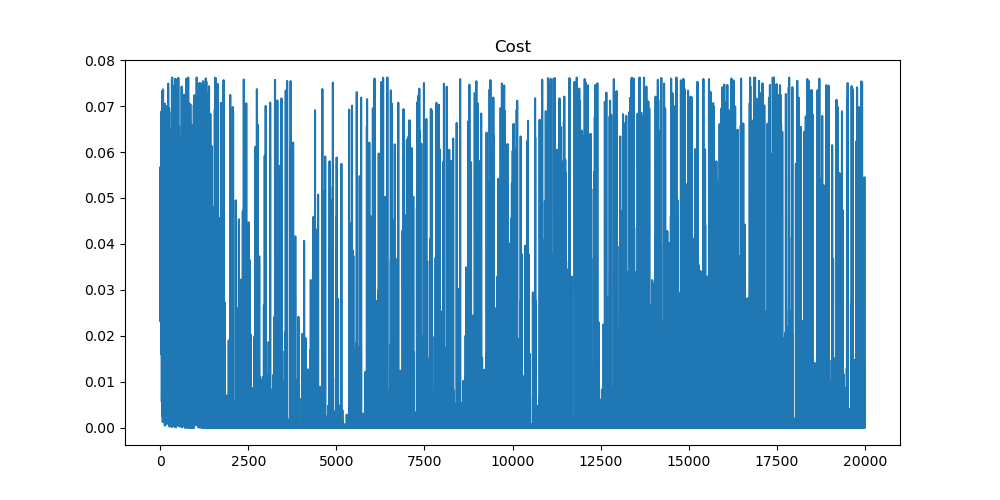

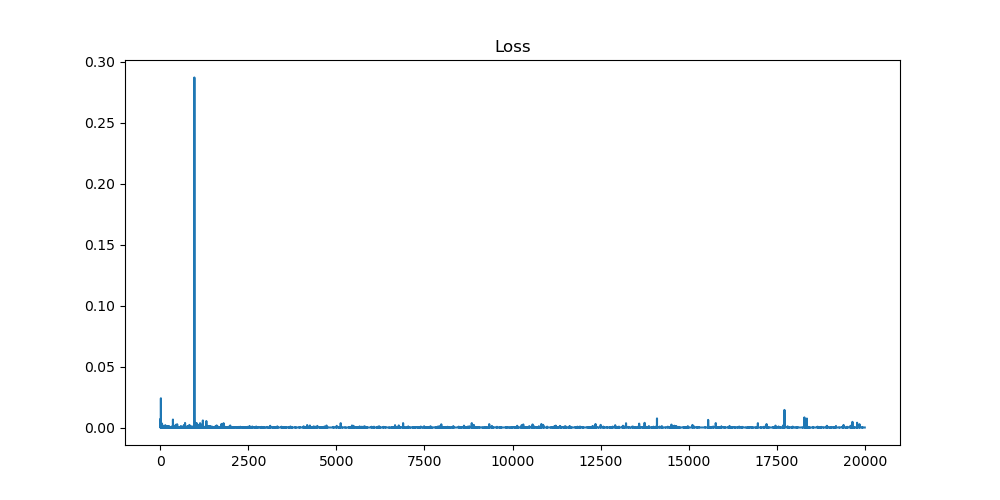

In [6]:
# plot the loss and cost
InvPen.plot_results()


In [7]:
# # find size of cost_list
# print(len(InvPen.cost_list))
# # find size of loss_list
# print(len(InvPen.loss_list))

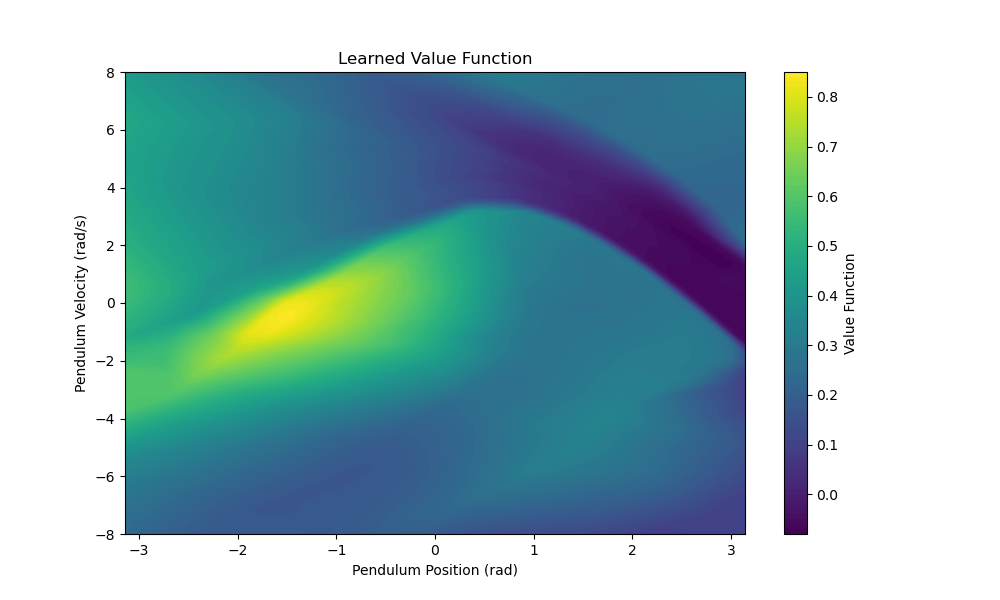

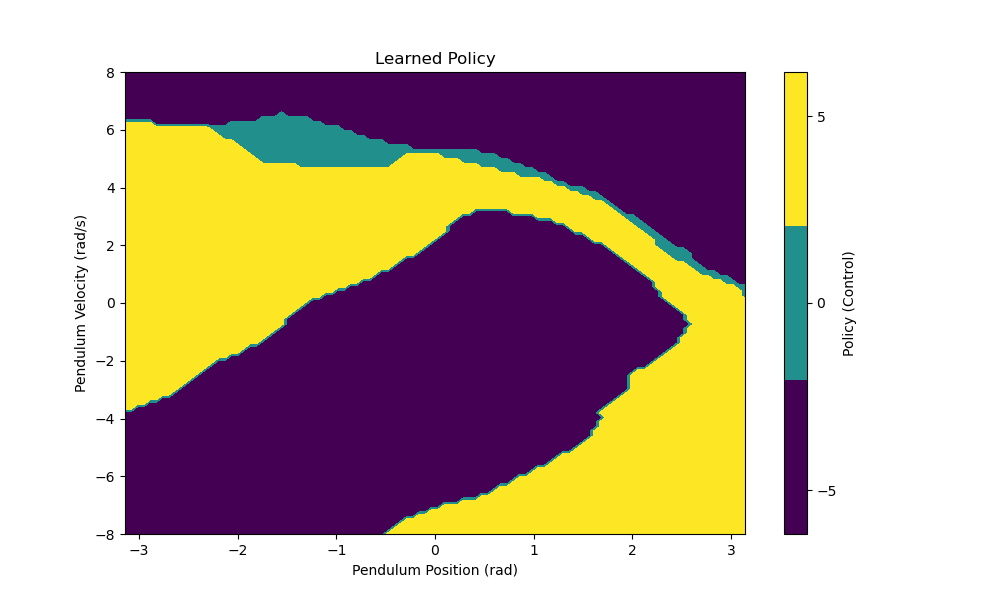

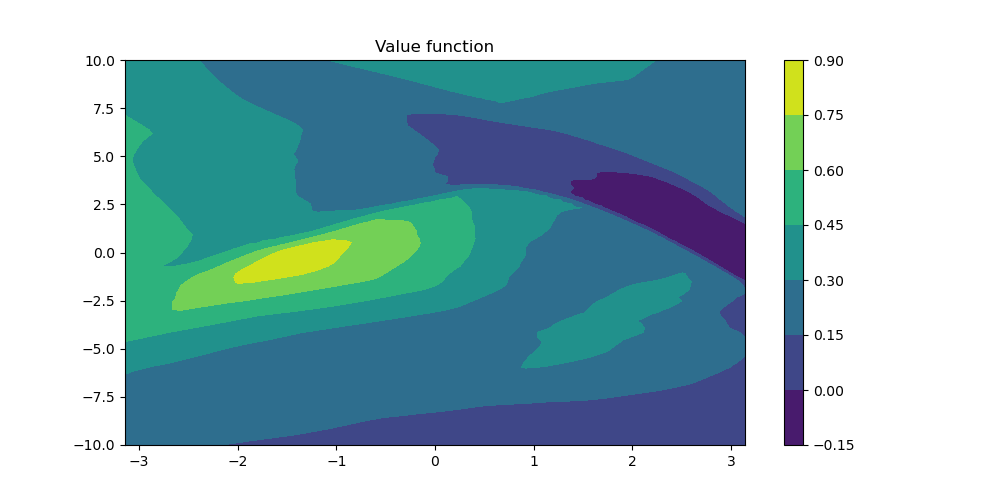

In [8]:
# plot the value function
InvPen.plot_value_function(q_function)
InvPen.plot_value_function_and_policy(q_function, possible_controls)